In [12]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#!git clone https://github.com/RATFIVE/GEOMAR-DeepLearning.git

In [43]:
#!rm -rf GEOMAR-DeepLearning/
#!ls -l

total 4
drwxr-xr-x 1 root root 4096 Feb 21 14:21 sample_data


In [1]:
%ls -l

total 8
drwxr-xr-x 4 root root 4096 Feb 26 12:44 GEOMAR-DeepLearning/
drwxr-xr-x 1 root root 4096 Feb 21 14:21 sample_data/


In [2]:

%cd GEOMAR-DeepLearning/app/backend

/content/GEOMAR-DeepLearning/app/backend


In [3]:
!pip install -r requirements.txt

In [5]:
# import all necessary libraries
import copy
import os
from PIL import Image
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import datetime
from utils.Copernicus import AdvancedCopernicus




# Display all columns
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [6]:
START_DATE = '2025-02-01'
END_DATE = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
OUTPUT_FILENAME = 'output.nc'

BBOX= {
    # "min_lon":10.038345850696412,
    # "max_lon":10.365962458698567,
    # "min_lat":54.27381478077755,
    # "max_lat":54.52976525577923,

    "minimum_longitude":9.85083510071235,
    "maximum_longitude":10.926709174713364,
    "minimum_latitude":54.25206332481298,
    "maximum_latitude":54.97306793985031,

    "target_min_lon":10.156,
    "target_max_lon":10.170,
    "target_min_lat":54.354,
    "target_max_lat":54.365
    }

In [7]:
copernicus = AdvancedCopernicus()
def load_ocean_data(variables=["bottomT", "mlotst", "siconc", "sithick", "sla", "so", "sob", "thetao", "uo", "vo", "wo"],
                    minimum_longitude=BBOX["minimum_longitude"],
                    maximum_longitude=BBOX["maximum_longitude"],
                    minimum_latitude=BBOX["minimum_latitude"],
                    maximum_latitude=BBOX["maximum_latitude"]):

    data = copernicus.get_subset(
        dataset_id="cmems_mod_bal_phy_anfc_PT1H-i",
        dataset_version="202411",
        variables=variables,
        minimum_longitude=minimum_longitude,
        maximum_longitude=maximum_longitude,
        minimum_latitude=minimum_latitude,
        maximum_latitude=maximum_latitude,
        start_datetime=START_DATE,
        end_datetime=END_DATE,
        minimum_depth=0.5016462206840515,
        maximum_depth=0.5016462206840515,
        coordinates_selection_method="strict-inside",
        disable_progress_bar=False,
        output_filename=OUTPUT_FILENAME)

    return data.to_dataframe().reset_index()

training_data = load_ocean_data(
    variables=["bottomT", "mlotst", "siconc", "sithick", "sla", "so", "sob", "thetao", "uo", "vo", "wo"],
    minimum_longitude=BBOX["minimum_longitude"],
    maximum_longitude=BBOX["maximum_longitude"],
    minimum_latitude=BBOX["minimum_latitude"],
    maximum_latitude=BBOX["maximum_latitude"]
)

target_data = load_ocean_data(
    variables=["sla"],
    minimum_longitude=BBOX["target_min_lon"],
    maximum_longitude=BBOX["target_max_lon"],
    minimum_latitude=BBOX["target_min_lat"],
    maximum_latitude=BBOX["target_max_lat"]
)

INFO - 2025-02-26T12:57:49Z - Selected dataset version: "202411"
INFO:copernicusmarine:Selected dataset version: "202411"
INFO - 2025-02-26T12:57:49Z - Selected dataset part: "default"
INFO:copernicusmarine:Selected dataset part: "default"
INFO - 2025-02-26T12:57:54Z - Starting download. Please wait...
INFO:copernicusmarine:Starting download. Please wait...


  0%|          | 0/330 [00:00<?, ?it/s]

INFO - 2025-02-26T12:58:14Z - Successfully downloaded to output.nc
INFO:copernicusmarine:Successfully downloaded to output.nc
INFO - 2025-02-26T12:58:16Z - Selected dataset version: "202411"
INFO:copernicusmarine:Selected dataset version: "202411"
INFO - 2025-02-26T12:58:16Z - Selected dataset part: "default"
INFO:copernicusmarine:Selected dataset part: "default"
INFO - 2025-02-26T12:58:18Z - Starting download. Please wait...
INFO:copernicusmarine:Starting download. Please wait...


  0%|          | 0/2 [00:00<?, ?it/s]

INFO - 2025-02-26T12:58:19Z - Successfully downloaded to output.nc
INFO:copernicusmarine:Successfully downloaded to output.nc


## IDA

In [8]:
def process_df(df):
    df = df.dropna(axis=1, how="all")
    df = df.dropna(axis=0, how="any")
    df = df[["time"] + [col for col in df.columns if col != "time"]]
    float_cols = df.select_dtypes(include=["float"]).columns
    df[float_cols] = df[float_cols].astype(np.float32)
    df["time"] = pd.to_datetime(df["time"]).dt.tz_localize(None).dt.round("h")
    df = df.reset_index(drop=True)
    return df

In [9]:
training_data = process_df(training_data)
display(training_data.head(3))
display(training_data.info())

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo
0,2025-02-01 00:00:00,0.501646,54.308277,10.708242,3.949874,11.431097,0.0,0.0,-0.094585,20.076197,20.076197,3.949874,0.0,-0.003346,-1.130791e-06
1,2025-02-01 01:00:00,0.501646,54.308277,10.708242,3.947661,11.449051,0.0,0.0,-0.076631,20.077806,20.077806,3.947661,0.0,-0.004077,-7.328313e-07
2,2025-02-01 02:00:00,0.501646,54.308277,10.708242,3.945188,11.472710,0.0,0.0,-0.052973,20.080185,20.080185,3.945187,0.0,-0.007542,-3.588450e-07


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655297 entries, 0 to 655296
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   time       655297 non-null  datetime64[ns]
 1   depth      655297 non-null  float32       
 2   latitude   655297 non-null  float32       
 3   longitude  655297 non-null  float32       
 4   bottomT    655297 non-null  float32       
 5   mlotst     655297 non-null  float32       
 6   siconc     655297 non-null  float32       
 7   sithick    655297 non-null  float32       
 8   sla        655297 non-null  float32       
 9   so         655297 non-null  float32       
 10  sob        655297 non-null  float32       
 11  thetao     655297 non-null  float32       
 12  uo         655297 non-null  float32       
 13  vo         655297 non-null  float32       
 14  wo         655297 non-null  float32       
dtypes: datetime64[ns](1), float32(14)
memory usage: 40.0 MB


None

In [10]:
target_data = process_df(target_data)
target_data.groupby(by=["time", 'latitude', 'longitude']).mean()
display(target_data.head(3))
display(target_data.info())
display(target_data['latitude'].unique())

,time,latitude,longitude,sla
0,2025-02-01 00:00:00,54.358276,10.152689,-0.120450
1,2025-02-01 01:00:00,54.358276,10.152689,-0.091966
2,2025-02-01 02:00:00,54.358276,10.152689,-0.065222


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       613 non-null    datetime64[ns]
 1   latitude   613 non-null    float32       
 2   longitude  613 non-null    float32       
 3   sla        613 non-null    float32       
dtypes: datetime64[ns](1), float32(3)
memory usage: 12.1 KB


None

array([54.358276], dtype=float32)

In [11]:
df_merged = pd.merge(training_data, target_data, on="time", how="inner", suffixes=("", "_target"))
display(df_merged.head(3))
display(df_merged.info())
display(df_merged.describe())

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo,latitude_target,longitude_target,sla_target
0,2025-02-01 00:00:00,0.501646,54.308277,10.708242,3.949874,11.431097,0.0,0.0,-0.094585,20.076197,20.076197,3.949874,0.0,-0.003346,-1.130791e-06,54.358276,10.152689,-0.120450
1,2025-02-01 01:00:00,0.501646,54.308277,10.708242,3.947661,11.449051,0.0,0.0,-0.076631,20.077806,20.077806,3.947661,0.0,-0.004077,-7.328313e-07,54.358276,10.152689,-0.091966
2,2025-02-01 02:00:00,0.501646,54.308277,10.708242,3.945188,11.472710,0.0,0.0,-0.052973,20.080185,20.080185,3.945187,0.0,-0.007542,-3.588450e-07,54.358276,10.152689,-0.065222


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655297 entries, 0 to 655296
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   time              655297 non-null  datetime64[ns]
 1   depth             655297 non-null  float32       
 2   latitude          655297 non-null  float32       
 3   longitude         655297 non-null  float32       
 4   bottomT           655297 non-null  float32       
 5   mlotst            655297 non-null  float32       
 6   siconc            655297 non-null  float32       
 7   sithick           655297 non-null  float32       
 8   sla               655297 non-null  float32       
 9   so                655297 non-null  float32       
 10  sob               655297 non-null  float32       
 11  thetao            655297 non-null  float32       
 12  uo                655297 non-null  float32       
 13  vo                655297 non-null  float32       
 14  wo  

None

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo,latitude_target,longitude_target,sla_target
count,655297,655297.000000,655297.000000,655297.000000,655297.000000,655297.000000,6.552970e+05,6.552970e+05,655297.000000,655297.000000,655297.000000,655297.000000,655297.000000,655297.000000,6.552970e+05,655297.000000,655297.000000,655297.000000
mean,2025-02-13 17:59:59.999999488,0.501646,54.660522,10.454243,3.944863,10.477656,3.851260e-08,3.295705e-07,-0.212955,15.355447,19.258900,3.310022,-0.030580,0.058944,-3.115574e-07,54.358337,10.152694,-0.218489
min,2025-02-01 00:00:00,0.501646,54.308277,9.874912,-0.591978,2.274687,0.000000e+00,0.000000e+00,-0.921992,8.571222,8.571222,-0.799094,-0.898166,-1.230932,-2.172987e-04,54.358276,10.152689,-0.816700
25%,2025-02-07 09:00:00,0.501646,54.524940,10.208244,3.519483,9.892342,0.000000e+00,0.000000e+00,-0.381349,13.244329,18.904844,2.928972,-0.080922,-0.020148,2.109744e-09,54.358276,10.152689,-0.408219
50%,2025-02-13 18:00:00,0.501646,54.658272,10.458243,3.899928,10.018789,0.000000e+00,0.000000e+00,-0.200005,15.667418,19.688967,3.371565,-0.016437,0.024090,3.892807e-07,54.358276,10.152689,-0.203643
75%,2025-02-20 03:00:00,0.501646,54.791603,10.680465,4.450098,10.158071,0.000000e+00,0.000000e+00,-0.040590,17.820160,20.383598,3.772726,0.028848,0.090696,1.467710e-06,54.358276,10.152689,-0.030179
max,2025-02-26 12:00:00,0.501646,54.958267,10.902686,7.357439,33.155102,1.039391e-02,9.997947e-02,0.236108,20.839090,23.257256,4.939826,0.761376,1.805505,5.789600e-05,54.358276,10.152689,0.213716
std,NaN,0.001464,0.262057,0.276817,0.732606,2.844023,1.897164e-05,1.755679e-04,0.212085,2.952886,2.153913,0.639559,0.119565,0.178987,9.952637e-06,0.156212,0.032812,0.228170


## EDA

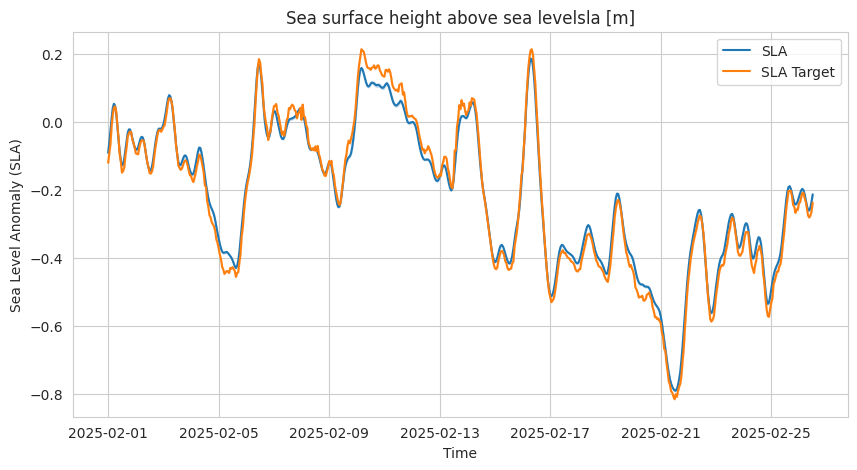

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for Seaborn
sns.set_style("whitegrid")

# Erstellen der Plot-Figur
plt.figure(figsize=(10, 5))

# Plot der SLA-Daten
sns.lineplot(x=df_merged["time"], y=df_merged["sla"], label="SLA")

# Plot der SLA Target-Daten
sns.lineplot(x=df_merged["time"], y=df_merged["sla_target"], label="SLA Target")

# Achsen und Titel setzen
plt.title("Sea surface height above sea levelsla [m]")
plt.xlabel("Time")
plt.ylabel("Sea Level Anomaly (SLA)")

# Legende anzeigen
plt.legend()

# Diagramm anzeigen
plt.show()


# Stationary

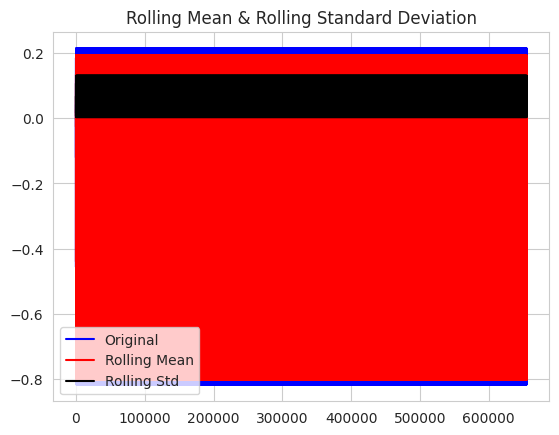

In [13]:
df_target = df_merged["sla_target"]

rolling_mean = df_target.rolling(window = 7).mean(numeric_only=True)
rolling_std = df_target.rolling(window = 7).std(numeric_only=True)
plt.plot(df_target, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [ ]:

from statsmodels.tsa.stattools import adfuller
def print_df_stats(series, order):
    x=series
    if (order>0):
        x=x.diff(order)[order:]
    result = adfuller(x)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

print_df_stats(df_target, 0)
print_df_stats(df_target, 1)

In [ ]:
# from statsmodels.tsa.stattools import acf, pacf

# diff_series=df_target.diff(2)[2:]

# lag_acf=acf(diff_series, nlags=7)
# lag_pacf=pacf(diff_series, nlags=7, method='ols')
# plt.figure(figsize=(20,10))
# plt.subplot(121)
# plt.plot(lag_acf)
# plt.axhline(y=0,linestyle='--',color='green')
# plt.axhline(y=-1.96/np.sqrt(len(diff_series)),linestyle='--',color='green')
# plt.axhline(y=1.96/np.sqrt(len(diff_series)),linestyle='--',color='green')
# plt.title('Autocorrelation Function')
# plt.subplot(122)
# plt.plot(lag_pacf)
# plt.axhline(y=0,linestyle='--',color='green')
# plt.axhline(y=-1.96/np.sqrt(len(diff_series)),linestyle='--',color='green')
# plt.axhline(y=1.96/np.sqrt(len(diff_series)),linestyle='--',color='green')
# plt.title('Partial Autocorrelation Function')

KeyboardInterrupt: 